`Last update at 2021-03-16`

# Background

## Rounds to test
```
Round 1: 60 MAGs; 39 MS/MS-BGC links (1 correct link)
Round 2: 279 genomes/MAGs; 1 MS/MS-BGC links (0 correct link)
Round 3: 279 genomes/MAGs and 589 metagenomes; 16 MS/MS-BGC links (8 correct links)
```

## Outline

```
    2) Creating MS/MS fingerprints:
    2.1) Compares all fragmentation spectra of a raw file to all reference spectra of a list;
    2.2) Run the search for all mzXML files of a specified directory; (estimated runtime of 29:04:27)
    2.3) Creating MS/MS fingerprints matrix (ispec_mat);
    2.4) Merging columns from same sample.
    
```

In [1]:
from pyteomics import mzxml
from pyteomics import mgf
from spectrum_alignment import *
import numpy as np
import pandas as pd
import subprocess
import os
import glob
import requests
import json
import time

# 2. Creating MS/MS fingerprints

## 2.1. Compares all fragmentation spectra of a raw file to all reference spectra of a list

In [2]:
def get_ms2df(file_name, speclist, pmztol=0.1, fragtol=0.1):
    rt = []
    mz = []
    inten = []
    prec_mz = []
    scan_num = []
    scores = []
    specids = []
    pmlist = []
    for spec in speclist:
        for k,v in spec.items():
            pmlist.append(v[0])
    pmlist = np.array(pmlist)
    with mzxml.read(file_name) as reader:
        for spectrum in reader:
                if spectrum['msLevel'] == 2:
                    p_mz = spectrum['precursorMz'][0].get('precursorMz')
                    loc = np.where(abs(pmlist-p_mz) < pmztol)[0]
                    if len(loc):
                        for i in loc:
                            qmz = spectrum['m/z array']
                            qint = spectrum['intensity array']
                            qspec = list(zip(qmz, qint))
                            pm1, spec1 = list(speclist[i].values())[0]
                            specid = list(speclist[i].keys())[0]
                            score = score_alignment(spec1, qspec, pm1, p_mz, fragtol)[0]
                            if score>0:
                                lqmz = len(qmz)
                                scan_num.extend([spectrum['num']] * lqmz)
                                rt.extend([spectrum['retentionTime']] * lqmz)
                                mz.extend(qmz)
                                inten.extend(qint)
                                prec_mz.extend([p_mz] * lqmz)
                                scores.extend([score] * lqmz)
                                specids.extend([specid] * lqmz)

    ms2_data = pd.DataFrame(
            {'prec_mz': prec_mz,
             'mz': mz,
             'inten': inten,
             'rt': rt,
             'scan_num': scan_num,
             'specids': specids,
             'scores': scores
            })
    return ms2_data

def get_library(lib, peaks=False):
    base_url = "gnps.ucsd.edu"
    if peaks:
        datasets_url = 'https://' + base_url + '/ProteoSAFe/LibraryServlet?library=' + lib + '&showpeaks=true'
    else:
        datasets_url = 'https://' + base_url + '/ProteoSAFe/LibraryServlet?library=' + lib
    json_obj = json.loads(requests.get(datasets_url).text)
    return json_obj['spectra']


In [3]:
libnames = pd.DataFrame(get_library('all'))
libnames.head()

,spectrum_id,source_file,task,scan,ms_level,library_membership,spectrum_status,peaks_json,splash,submit_user,...,Pubmed_ID,Smiles,INCHI,INCHI_AUX,Library_Class,SpectrumID,Ion_Mode,create_time,task_id,user_id
0,CCMSLIB00000001547,130618_Ger_Jenia_WT-3-Des-MCLR_MH981.4-qb.1.1....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,null,splash10-0w2a-0001282259-0001282259,mwang87,...,N/A,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,N/A,N/A,1,CCMSLIB00000001547,Positive,2019-10-30 21:18:25.0,aa87bf9cd0784df9956753f435c32434,null
1,CCMSLIB00000001548,20111105_Anada_Ger_HoiamideB_MH940_qb.1.1..mgf,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,null,splash10-00dl-0000011189-0000011189,mwang87,...,N/A,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,InChI=1S/C45H73N5O10S3/c1-14-17-24(6)34(52)26(...,N/A,1,CCMSLIB00000001548,Positive,2019-06-04 02:55:49.0,cd4ed49954b94767a54918c340d18fa1,null
2,CCMSLIB00000001549,20111105_Jenia_Ger_MalyngamideC_MH_456_qb.1.1....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,null,splash10-00di-0000900000-0000900000,mwang87,...,N/A,CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...,InChI=1S/C24H38ClNO5/c1-3-4-5-6-8-11-19(30-2)1...,N/A,1,CCMSLIB00000001549,Positive,2021-03-18 16:28:20.0,48c1656fa4464fea93b71bfd79e0faa5,null
3,CCMSLIB00000001550,20111105_Jenia_Ger_Scytonemin_MH_545_qb.1.1..mgf,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,null,splash10-0002-0000190000-0000190000,mwang87,...,N/A,OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...,InChI=1S/C36H20N2O4/c39-21-13-9-19(10-14-21)17...,CGZKSPLDUIRCIO-RPCRKUJJSA-N,1,CCMSLIB00000001550,Positive,2019-07-23 10:38:26.0,ca48cf7bc6644f5e89f98d62f114dfea,null
4,CCMSLIB00000001551,A1.mgf,d14a5843653040ba9fa2c4376f2be358,1,2,GNPS-LIBRARY,1,null,splash10-03di-0910000000-0910000000,mwang87,...,N/A,N/A,N/A,N/A,1,CCMSLIB00000001551,Positive,2014-02-04 17:56:31.0,d14a5843653040ba9fa2c4376f2be358,null


In [4]:
# Creates a list of reference spectra from mgf files stored in specified directory
fmgf = [x for x in os.listdir('selected_mgf_round3.8/') if '.mgf' in x]

speclist = []
for i in range(len(fmgf)):
    with mgf.MGF('selected_mgf_round3.8/%s' % fmgf[i]) as reader: 
        for spectrum in reader:
            speclist.append({fmgf[i][:18] : [spectrum['params']['pepmass'][0], 
                                            list(zip(spectrum['m/z array'], spectrum['intensity array']))]
                            } 
            )


In [5]:
len(glob.glob('/Volumes/TFL190831/podp_LCMS/*'))

1723

## 2.2. Run the search for all mzXML files of a specified directory

In [6]:
start = time.time()

dirlist = glob.glob('/Volumes/TFL190831/podp_LCMS/*')

mxlist,excluded_list = [],[]
for dr in dirlist:
    print(dr)
    try:
        ms2_data = get_ms2df(dr, speclist)
        mxlist.append(ms2_data.loc[ms2_data.groupby(['scan_num'])['scores'].idxmax()])
    except:
        excluded_list.append(dr)
        
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

/Volumes/TFL190831/podp_LCMS/ERS4341365.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000240165.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000240165.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000240165.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000240165.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000240165.mzXML.5
/Volumes/TFL190831/podp_LCMS/GCA_000240165.mzXML.6
/Volumes/TFL190831/podp_LCMS/GCA_000240165.mzXML.7
/Volumes/TFL190831/podp_LCMS/GCA_000240165.mzXML.8
/Volumes/TFL190831/podp_LCMS/GCA_000240165.mzXML.9
/Volumes/TFL190831/podp_LCMS/GCA_000240165.mzXML.10
/Volumes/TFL190831/podp_LCMS/GCA_000240165.mzXML.11
/Volumes/TFL190831/podp_LCMS/GCA_000240165.mzXML.12
/Volumes/TFL190831/podp_LCMS/GCA_000240165.mzXML.13
/Volumes/TFL190831/podp_LCMS/GCA_000240165.mzXML.14
/Volumes/TFL190831/podp_LCMS/GCA_000240165.mzXML.15
/Volumes/TFL190831/podp_LCMS/GCA_000240165.mzXML.16
/Volumes/TFL190831/podp_LCMS/GCA_000240165.mzXML.17
/Volumes/TFL190831/podp_LCMS/GCA_000240165.mzXML.18
/Volumes/TFL190831/podp_L

/Volumes/TFL190831/podp_LCMS/GCA_000414585.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000414565.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000414525.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000414505.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000414485.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000414445.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000414425.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000218465.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000712235.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000244855.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000233535.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000214475.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000234075.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000183585.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000763055.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000158375.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000147235.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000090945.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000209465.mzXML.1
/Volumes/TFL190831/podp_LCMS/GC

/Volumes/TFL190831/podp_LCMS/GCA_000712235.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000244855.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000233535.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000214475.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000234075.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000183585.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000763055.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000158375.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000147235.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000090945.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000209465.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000273605.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000277625.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000287675.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000162275.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000478945.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000517705.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000524395.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000294005.mzXML.2
/Volumes/TFL190831/podp_LCMS/GC

/Volumes/TFL190831/podp_LCMS/GCA_000261205.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000411435.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000513015.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000466465.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000414705.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000414685.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000414665.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000414645.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000414625.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000414605.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000414585.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000414565.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000414525.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000414505.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000414485.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000414445.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000414425.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000218465.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000712235.mzXML.3
/Volumes/TFL190831/podp_LCMS/GC

/Volumes/TFL190831/podp_LCMS/GCA_000414625.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000414605.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000414585.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000414565.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000414525.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000414505.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000414485.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000414445.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000414425.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000218465.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000712235.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000244855.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000233535.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000214475.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000234075.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000183585.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000763055.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000158375.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000147235.mzXML.4
/Volumes/TFL190831/podp_LCMS/GC

/Volumes/TFL190831/podp_LCMS/GCA_000087965.mzXML.9
/Volumes/TFL190831/podp_LCMS/GCA_000087965.mzXML.10
/Volumes/TFL190831/podp_LCMS/GCA_002941025.mzML.1
/Volumes/TFL190831/podp_LCMS/GCA_000506385.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000506385.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000012265.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_003324555.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000012445.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_001562525.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_002899455.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_003248315.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_001625105.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_001625105.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000377965.mzXML.1
/Volumes/TFL190831/podp_LCMS/GCA_000377965.mzXML.2
/Volumes/TFL190831/podp_LCMS/GCA_000377965.mzXML.3
/Volumes/TFL190831/podp_LCMS/GCA_000377965.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000377965.mzXML.5
/Volumes/TFL190831/podp_LCMS/GCA_000377965.mzXML.6
/Volumes/TFL190831/podp_LCMS/GC

/Volumes/TFL190831/podp_LCMS/GCA_000424765.mzXML.5
/Volumes/TFL190831/podp_LCMS/GCA_000424765.mzXML.6
/Volumes/TFL190831/podp_LCMS/GCA_000424785.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000424785.mzXML.5
/Volumes/TFL190831/podp_LCMS/GCA_000424785.mzXML.6
/Volumes/TFL190831/podp_LCMS/GCA_000514995.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000514995.mzXML.5
/Volumes/TFL190831/podp_LCMS/GCA_000514995.mzXML.6
/Volumes/TFL190831/podp_LCMS/GCA_000377145.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000377145.mzXML.5
/Volumes/TFL190831/podp_LCMS/GCA_000377145.mzXML.6
/Volumes/TFL190831/podp_LCMS/GCA_000377545.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000377545.mzXML.5
/Volumes/TFL190831/podp_LCMS/GCA_000377545.mzXML.6
/Volumes/TFL190831/podp_LCMS/GCA_000377165.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000377165.mzXML.5
/Volumes/TFL190831/podp_LCMS/GCA_000377165.mzXML.6
/Volumes/TFL190831/podp_LCMS/GCA_000213055.mzXML.4
/Volumes/TFL190831/podp_LCMS/GCA_000213055.mzXML.5
/Volumes/TFL190831/podp_LCMS/GC

/Volumes/TFL190831/podp_LCMS/ERS4341368.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341369.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341370.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341371.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341372.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341373.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341374.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341375.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341376.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341377.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341378.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341379.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341380.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341381.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341382.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341383.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341384.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341385.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341386.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341387.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341388.

/Volumes/TFL190831/podp_LCMS/ERS4341544.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341545.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341546.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341547.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341548.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341549.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341550.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341551.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341552.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341553.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341555.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341556.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341557.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341558.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341560.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341561.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341562.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341563.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341564.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341565.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4341566.

/Volumes/TFL190831/podp_LCMS/ERS4346406.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346409.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346410.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346411.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346412.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346413.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346414.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346415.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346417.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346418.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346419.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346420.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346421.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346422.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346423.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346424.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346425.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346426.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346427.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346428.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4346429.

/Volumes/TFL190831/podp_LCMS/ERS4346598.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356164.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356166.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356177.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356239.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356178.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356183.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356185.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356188.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356189.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356195.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356200.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356203.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356204.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356211.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356215.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356219.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356225.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356227.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356234.mzXML.1
/Volumes/TFL190831/podp_LCMS/ERS4356237.

In [7]:
refn = [x[:-4] for x in fmgf]
specn = os.listdir("/Volumes/TFL190831/podp_LCMS/")

In [8]:
len(excluded_list),len(specn)

(347, 2249)

In [9]:
clean_excluded_list = []

for item in excluded_list:
    clean_excluded_list.append(os.path.basename(item))
    
len(clean_excluded_list)

347

In [10]:
filt_specn = []

for item in specn:
    if '._' not in item:
        if item not in clean_excluded_list:
            filt_specn.append(item)
        
len(filt_specn)

1376

## 2.3. Creating MS/MS fingerprints matrix (ispec_mat)

In [11]:
# create empty data frame using the names above as indexes
ispec_mat = pd.DataFrame(0, index=refn, columns=filt_specn)

In [12]:
# Fill the matrix with the highest score for a given reference spectrum in a givem sample
for i in range(len(filt_specn)):
    mtmp = mxlist[i].loc[mxlist[i].groupby(['specids'])['scores'].idxmax()]
    ispec_mat.loc[mtmp['specids'], filt_specn[i]] = mtmp['scores'].tolist()

In [13]:
ispec_mat

,ERS4341365.mzXML.1,GCA_000240165.mzXML.1,GCA_000240165.mzXML.2,GCA_000240165.mzXML.3,GCA_011290345.mzXML.1,GCA_011290345.mzXML.2,GCA_011290345.mzXML.3,GCA_000506385.mzXML.1,GCA_000506385.mzXML.2,GCA_000012265.mzXML.1,...,ERS4356314.mzXML.1,ERS4356315.mzXML.1,ERS4356317.mzXML.1,ERS4356319.mzXML.1,ERS4356320.mzXML.1,ERS4356321.mzXML.1,ERS4356322.mzXML.1,ERS4356323.mzXML.1,ERS4356324.mzXML.1,ERS4341364.mzXML.1
CCMSLIB00004708843,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004720895,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.003681,0.000000,0.000000,0.000000,0.000000,0.000000,0.001696,0.000000,0.0
CCMSLIB00000426015,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004684845,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00000217939,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00004681481,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00000572720,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004721623,0.0,0.123055,0.0,0.000000,0.0,0.0,0.0,0.000000,0.437479,0.0,...,0.162297,0.241437,0.185758,0.182472,0.175575,0.196460,0.198714,0.000000,0.186469,0.0
CCMSLIB00004721179,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.072798,0.103998,0.086590,0.000000,0.099330,0.122576,0.000000,0.018233,0.107091,0.0


In [14]:
(ispec_mat>0.7).sum().sum()

2260

In [15]:
ispec_mat.shape

(300, 1376)

In [16]:
ispec_mat = ispec_mat[(ispec_mat.T != 0).any()]

In [17]:
ispec_mat = ispec_mat.fillna(0)

ispec_mat

,ERS4341365.mzXML.1,GCA_000240165.mzXML.1,GCA_000240165.mzXML.2,GCA_000240165.mzXML.3,GCA_011290345.mzXML.1,GCA_011290345.mzXML.2,GCA_011290345.mzXML.3,GCA_000506385.mzXML.1,GCA_000506385.mzXML.2,GCA_000012265.mzXML.1,...,ERS4356314.mzXML.1,ERS4356315.mzXML.1,ERS4356317.mzXML.1,ERS4356319.mzXML.1,ERS4356320.mzXML.1,ERS4356321.mzXML.1,ERS4356322.mzXML.1,ERS4356323.mzXML.1,ERS4356324.mzXML.1,ERS4341364.mzXML.1
CCMSLIB00004720895,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.003681,0.000000,0.000000,0.000000,0.000000,0.000000,0.001696,0.000000,0.0
CCMSLIB00000217939,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004720881,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004702361,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00000567505,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00005724314,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004681481,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004721623,0.0,0.123055,0.0,0.000000,0.0,0.0,0.0,0.000000,0.437479,0.0,...,0.162297,0.241437,0.185758,0.182472,0.175575,0.196460,0.198714,0.000000,0.186469,0.0
CCMSLIB00004721179,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.072798,0.103998,0.086590,0.000000,0.099330,0.122576,0.000000,0.018233,0.107091,0.0


In [18]:
ispec_mat.shape

(273, 1376)

In [19]:
lib_df = libnames.loc[libnames['SpectrumID'].isin(refn), ['Compound_Name', 'SpectrumID']]

lib_df.to_csv('./outputs/libnames-round3.8-TFL210401.tsv',sep='\t')

/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


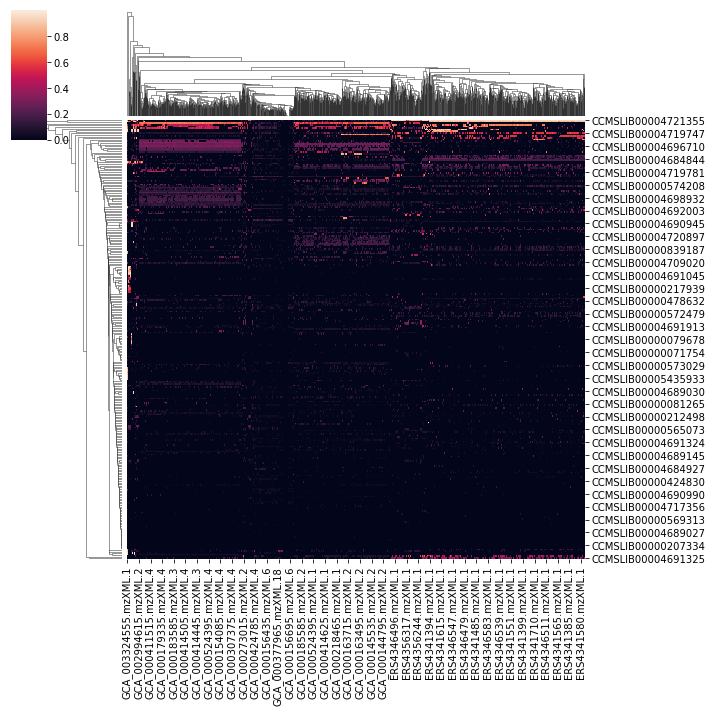

In [20]:
import seaborn as sns

sns.clustermap(ispec_mat)

In [21]:
strain_count = []

for item in ispec_mat.columns:
    strain = item.split('.')[0]
    if strain not in strain_count:
        strain_count.append(strain)
        
len(strain_count)

786

## 2.4. Merging columns from same sample

In [22]:
ispec_mat_trans = ispec_mat.T
processed_list = []

merged_ispec_mat = pd.DataFrame()

for i,r in ispec_mat_trans.iterrows():
    strain = i.split('.')[0]
    if strain not in processed_list:
        print(i,strain)
        processed_list.append(strain)
        ispec_temp = ispec_mat_trans[ispec_mat_trans.index.map(lambda x: strain in x)]
        if len(ispec_temp) == 1:
            merged_ispec_mat[strain] = ispec_temp.loc[ispec_temp.index[0], :].values.tolist()
        else:
            merged_ispec_mat[strain] = list(ispec_temp.max(axis=0))

ERS4341365.mzXML.1 ERS4341365
GCA_000240165.mzXML.1 GCA_000240165
GCA_011290345.mzXML.1 GCA_011290345
GCA_000506385.mzXML.1 GCA_000506385
GCA_000012265.mzXML.1 GCA_000012265
GCA_003324555.mzXML.1 GCA_003324555
GCA_000012445.mzXML.1 GCA_000012445
GCA_001562525.mzXML.1 GCA_001562525
GCA_002899455.mzXML.1 GCA_002899455
GCA_003248315.mzXML.1 GCA_003248315
GCA_001625105.mzXML.1 GCA_001625105
GCA_000710405.mzXML.1 GCA_000710405
GCA_000413395.mzXML.1 GCA_000413395
GCA_000466545.mzXML.1 GCA_000466545
GCA_000466585.mzXML.1 GCA_000466585
GCA_000160635.mzXML.1 GCA_000160635
GCA_000214315.mzXML.1 GCA_000214315
GCA_000162155.mzXML.1 GCA_000162155
GCA_000162215.mzXML.1 GCA_000162215
GCA_000157015.mzXML.1 GCA_000157015
GCA_000273465.mzXML.1 GCA_000273465
GCA_000218325.mzXML.1 GCA_000218325
GCA_000159875.mzXML.1 GCA_000159875
GCA_000175315.mzXML.1 GCA_000175315
GCA_000185585.mzXML.1 GCA_000185585
GCA_000157075.mzXML.1 GCA_000157075
GCA_000159075.mzXML.1 GCA_000159075
GCA_000158335.mzXML.1 GCA_00015833

ERS4341456.mzXML.1 ERS4341456
ERS4341457.mzXML.1 ERS4341457
ERS4341458.mzXML.1 ERS4341458
ERS4341459.mzXML.1 ERS4341459
ERS4341460.mzXML.1 ERS4341460
ERS4341461.mzXML.1 ERS4341461
ERS4341462.mzXML.1 ERS4341462
ERS4341463.mzXML.1 ERS4341463
ERS4341464.mzXML.1 ERS4341464
ERS4341465.mzXML.1 ERS4341465
ERS4341466.mzXML.1 ERS4341466
ERS4341467.mzXML.1 ERS4341467
ERS4341469.mzXML.1 ERS4341469
ERS4341470.mzXML.1 ERS4341470
ERS4341471.mzXML.1 ERS4341471
ERS4341472.mzXML.1 ERS4341472
ERS4341473.mzXML.1 ERS4341473
ERS4341474.mzXML.1 ERS4341474
ERS4341475.mzXML.1 ERS4341475
ERS4341476.mzXML.1 ERS4341476
ERS4341477.mzXML.1 ERS4341477
ERS4341478.mzXML.1 ERS4341478
ERS4341479.mzXML.1 ERS4341479
ERS4341480.mzXML.1 ERS4341480
ERS4341481.mzXML.1 ERS4341481
ERS4341482.mzXML.1 ERS4341482
ERS4341483.mzXML.1 ERS4341483
ERS4341484.mzXML.1 ERS4341484
ERS4341485.mzXML.1 ERS4341485
ERS4341486.mzXML.1 ERS4341486
ERS4341487.mzXML.1 ERS4341487
ERS4341488.mzXML.1 ERS4341488
ERS4341489.mzXML.1 ERS4341489
ERS4341490

ERS4346437.mzXML.1 ERS4346437
ERS4346438.mzXML.1 ERS4346438
ERS4346439.mzXML.1 ERS4346439
ERS4346440.mzXML.1 ERS4346440
ERS4346441.mzXML.1 ERS4346441
ERS4346442.mzXML.1 ERS4346442
ERS4346443.mzXML.1 ERS4346443
ERS4346444.mzXML.1 ERS4346444
ERS4346445.mzXML.1 ERS4346445
ERS4346446.mzXML.1 ERS4346446
ERS4346448.mzXML.1 ERS4346448
ERS4346449.mzXML.1 ERS4346449
ERS4346450.mzXML.1 ERS4346450
ERS4346451.mzXML.1 ERS4346451
ERS4346452.mzXML.1 ERS4346452
ERS4346453.mzXML.1 ERS4346453
ERS4346455.mzXML.1 ERS4346455
ERS4346456.mzXML.1 ERS4346456
ERS4346457.mzXML.1 ERS4346457
ERS4346458.mzXML.1 ERS4346458
ERS4346459.mzXML.1 ERS4346459
ERS4346460.mzXML.1 ERS4346460
ERS4346461.mzXML.1 ERS4346461
ERS4346462.mzXML.1 ERS4346462
ERS4346463.mzXML.1 ERS4346463
ERS4346465.mzXML.1 ERS4346465
ERS4346466.mzXML.1 ERS4346466
ERS4346467.mzXML.1 ERS4346467
ERS4346468.mzXML.1 ERS4346468
ERS4346470.mzXML.1 ERS4346470
ERS4346471.mzXML.1 ERS4346471
ERS4346472.mzXML.1 ERS4346472
ERS4346473.mzXML.1 ERS4346473
ERS4346474

In [23]:
ispec_mat_trans[ispec_mat_trans.index.map(lambda x: 'GCA_000240165' in x)]

,CCMSLIB00004720895,CCMSLIB00000217939,CCMSLIB00004720881,CCMSLIB00004702361,CCMSLIB00000567505,CCMSLIB00004721779,CCMSLIB00000075321,CCMSLIB00000205118,CCMSLIB00004689144,CCMSLIB00000078177,...,CCMSLIB00004689142,CCMSLIB00001058188,CCMSLIB00004696710,CCMSLIB00004689977,CCMSLIB00000221137,CCMSLIB00005724314,CCMSLIB00004681481,CCMSLIB00004721623,CCMSLIB00004721179,CCMSLIB00000220215
GCA_000240165.mzXML.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.121183,0.0,0.0,0.123055,0.0,0.000000
GCA_000240165.mzXML.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.057575,0.057056,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
GCA_000240165.mzXML.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.047349,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.032684
GCA_000240165.mzXML.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.121183,0.0,0.0,0.123055,0.0,0.000000
GCA_000240165.mzXML.49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.047349,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.032684
GCA_000240165.mzXML.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.057575,0.057056,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000


In [24]:
merged_ispec_mat.index = list(ispec_mat.index)

merged_ispec_mat

,ERS4341365,GCA_000240165,GCA_011290345,GCA_000506385,GCA_000012265,GCA_003324555,GCA_000012445,GCA_001562525,GCA_002899455,GCA_003248315,...,ERS4356314,ERS4356315,ERS4356317,ERS4356319,ERS4356320,ERS4356321,ERS4356322,ERS4356323,ERS4356324,ERS4341364
CCMSLIB00004720895,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.003681,0.000000,0.000000,0.000000,0.000000,0.000000,0.001696,0.000000,0.0
CCMSLIB00000217939,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004720881,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004702361,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00000567505,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00005724314,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004681481,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CCMSLIB00004721623,0.0,0.123055,0.0,0.437479,0.0,0.0,0.725891,0.711771,0.666782,0.640959,...,0.162297,0.241437,0.185758,0.182472,0.175575,0.196460,0.198714,0.000000,0.186469,0.0
CCMSLIB00004721179,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.072798,0.103998,0.086590,0.000000,0.099330,0.122576,0.000000,0.018233,0.107091,0.0


In [25]:
len(merged_ispec_mat.columns)

786

In [26]:
merged_ispec_mat.to_csv("./outputs/mass-affinity_df-round3.8-TFL210401.txt",sep="\t",index_label=False)

/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


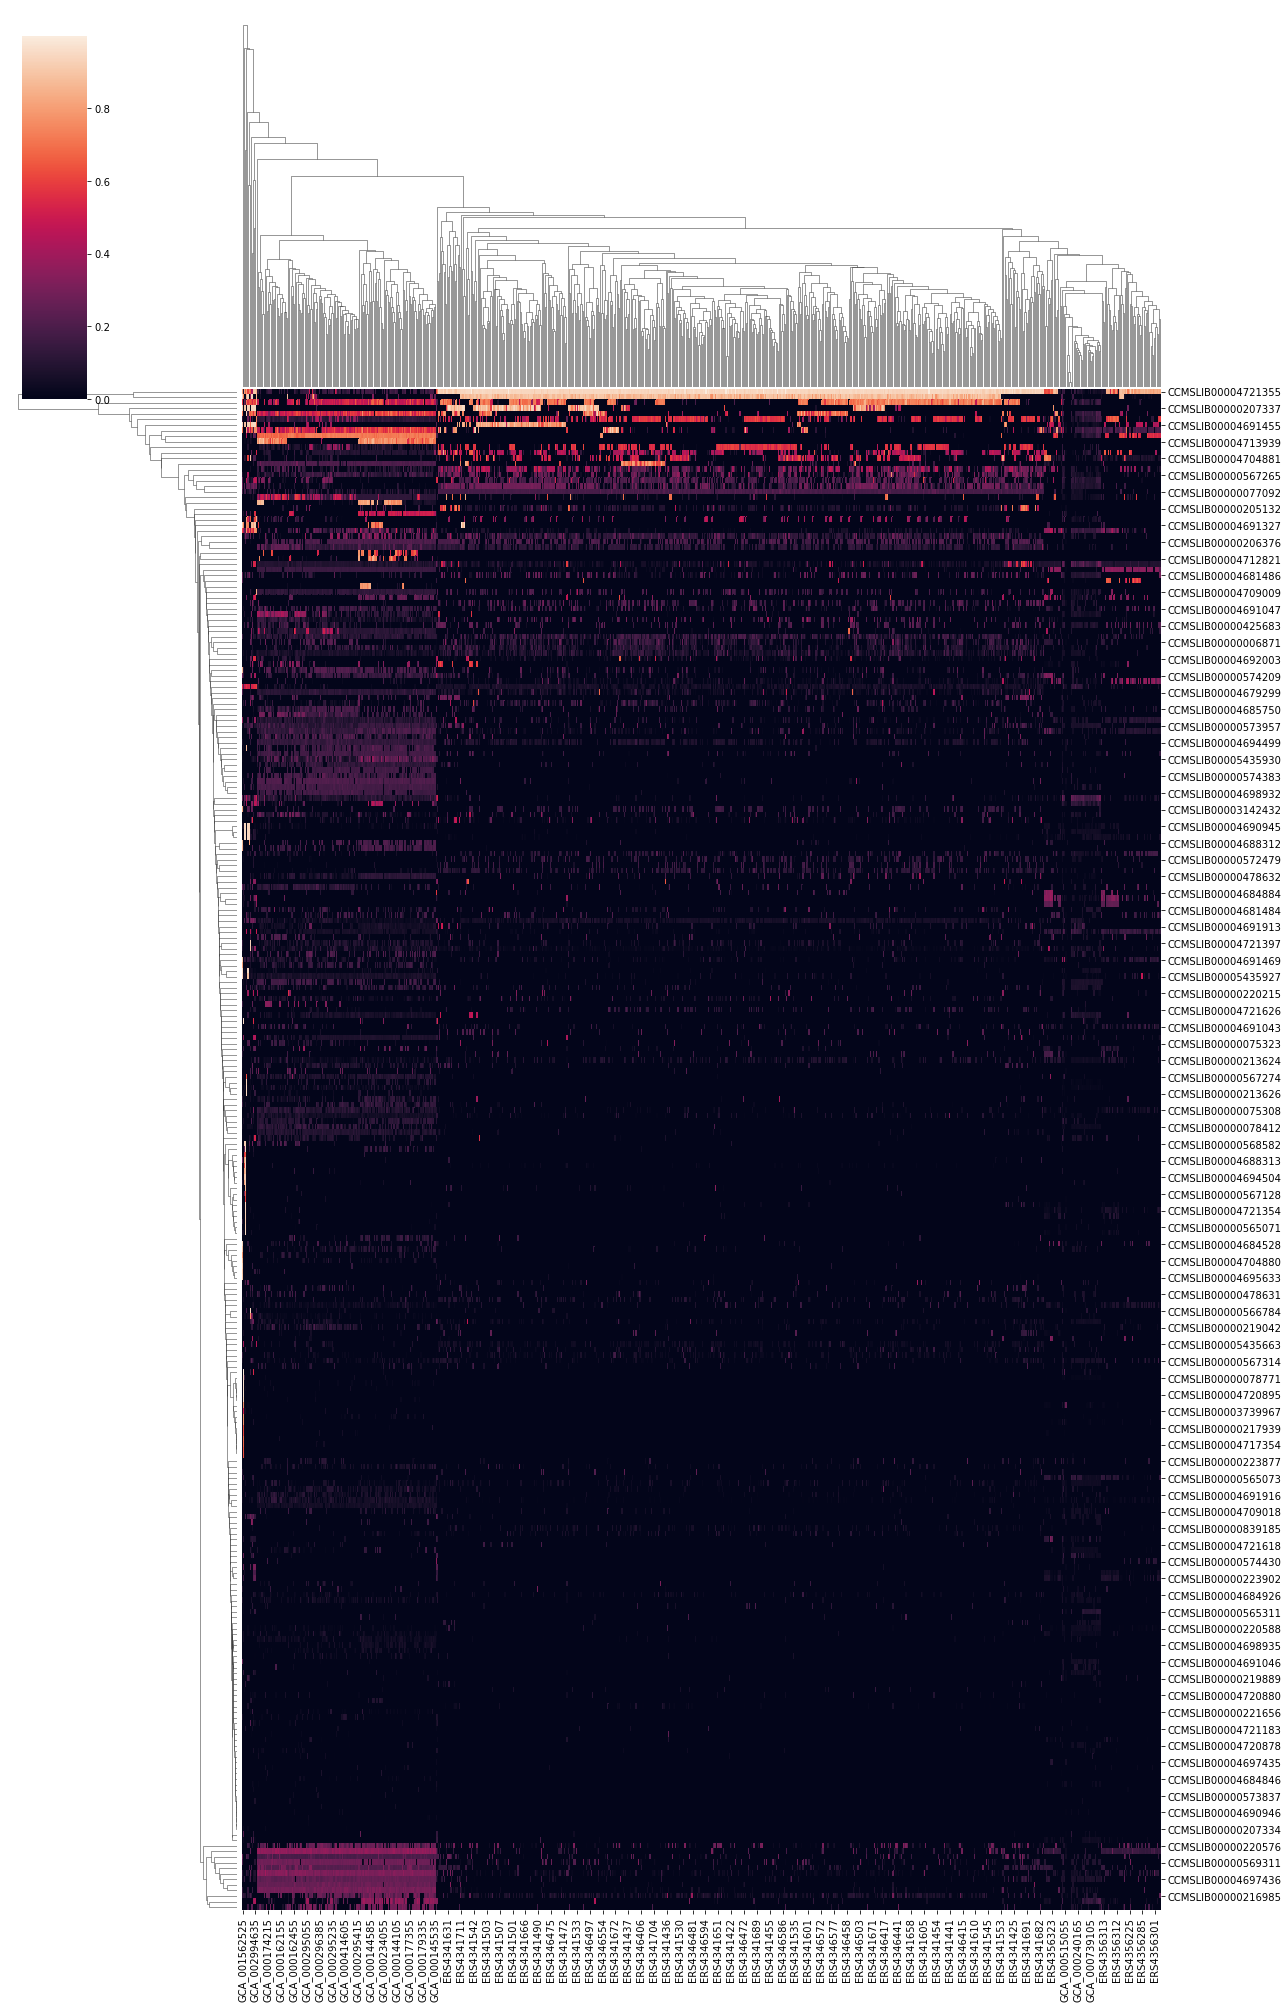

In [27]:
sns.clustermap(merged_ispec_mat,figsize=[18,28])